# **Hypothesis 2 - Weather Conditions Affect Pollutant Levels**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write down which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [17]:
os.chdir(r"c:\Users\sonia\Documents\VS Studio Projects\US_Air_Pollution_Team_2")

os.getcwd()

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2'

Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2'

---

# Required Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import normaltest
import pingouin as pg

---

## Load the Dataset

I will load the dataset using Pandas.

In [5]:
df = pd.read_csv('Dataset/EDA/pollution_us_2012_2016-population-weather.csv') # Reading the CSV file
pd.set_option("display.max_columns", None)
df.head()


Address    State County    City  Date Local   NO2 Mean  \
0  400 W RIVER ROAD  Arizona   Pima  Tucson  2012-01-01  17.716667   
1  400 W RIVER ROAD  Arizona   Pima  Tucson  2012-01-02  15.062500   
2  400 W RIVER ROAD  Arizona   Pima  Tucson  2012-01-03  21.643478   
3  400 W RIVER ROAD  Arizona   Pima  Tucson  2012-01-04  25.041668   
4  400 W RIVER ROAD  Arizona   Pima  Tucson  2012-01-05  21.981817   

   NO2 1st Max Value  NO2 1st Max Hour  NO2 AQI   O3 Mean  O3 1st Max Value  \
0               31.0                 0       29  0.013667             0.030   
1               30.6                18       28  0.015083             0.030   
2               31.0                18       29  0.011417             0.026   
3               37.8                10       35  0.009208             0.020   
4               37.1                17       35  0.013042             0.031   

   O3 1st Max Hour  O3 AQI  SO2 Mean  SO2 1st Max Value  SO2 1st Max Hour  \
0               10      25  0.254167                0.5                19   
1               10      25  0.200000                0.6                19   
2                9      22  0.295455                0.7                 8   
3               10      17  0.737500                2.1                19   
4                9      26  0.330435                0.8                21   

   SO2 AQI   CO Mean  CO 1st Max Value  CO 1st Max Hour  CO AQI Population  \
0      0.0  0.336842               0.6                5     7.0    542,649   
1      0.0  0.225000               0.4               23     5.0    542,649   
2      0.0  0.295833               0.4                0     5.0    542,649   
3      3.0  0.345833               0.5               12     6.0    542,649   
4      0.0  0.291667               0.6               23     7.0    542,649   

   Latitude  Longitude  tmax  prcp  wspd  
0   31.9681  -111.7806  26.7   0.0  17.6  
1   31.9681  -111.7806  24.4   0.0  27.4  
2   31.9681  -111.7806  26.1   0.0  10.8  
3   31.9681  -111.7806  24.4   0.0   9.0  
4   31.9681  -111.7806  23.9   0.0   9.7

In [6]:
df['Date Local'] = pd.to_datetime(df['Date Local'])

In [7]:
df['Population'] = df['Population'].str.replace(',', '').astype(int)

---

## Correlations Between Pollutants and Weather

During EDA, I found that maximum temperature, precipitation and wind speed could all affect pollutant levels. However, the relationships are not linear (see below).

Therefore, I am going to bin each of the weather conditions into low, medium or high values, and then test changes in distribution for the mean and maximum value of each pollutant.

Below is a recap of what was shown in the EDA.

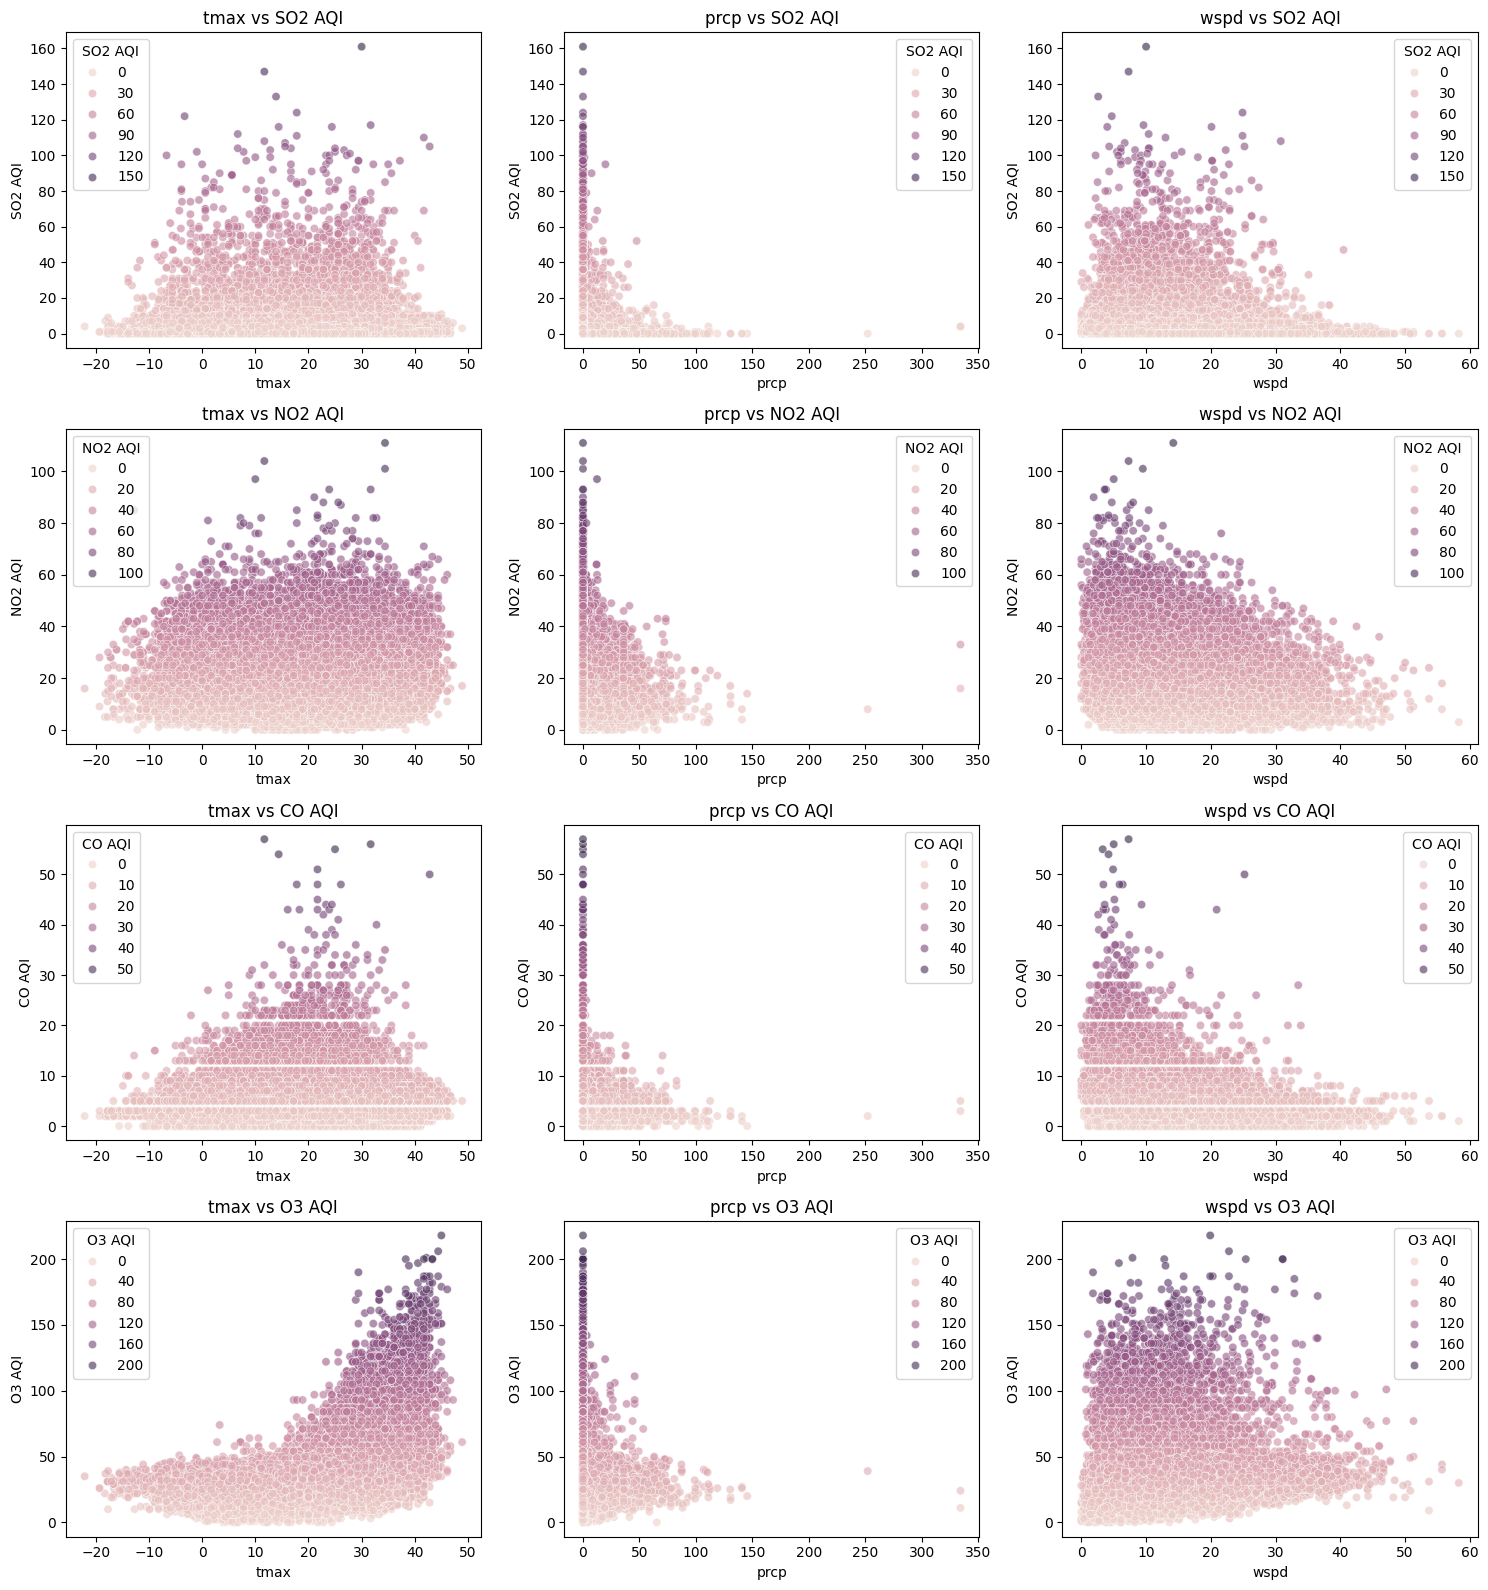

In [10]:
# Define your x and y variable sets
y_cols = ["SO2 AQI", "NO2 AQI", "CO AQI", "O3 AQI"]
x_cols = ["tmax", "prcp", "wspd"]  # 3 x-variables per y

# Calculate total number of plots
n = len(y_cols) * len(x_cols)
ncols = 3  # since 3 x-variables per y
nrows = len(y_cols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

idx = 0
for y_col in y_cols:
    for x_col in x_cols:
        sns.scatterplot(
            x=x_col,
            y=y_col,
            data=df,
            hue=y_col,
            alpha=0.6,
            ax=axes[idx]
        )
        axes[idx].set_title(f"{x_col} vs {y_col}")
        axes[idx].set_xlabel(x_col)
        axes[idx].set_ylabel(y_col)
        idx += 1

# Hide unused subplots if any
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

---

## Pollutant Levels and Maximum Temperature

Here, I am binning maximum temperature (tmax) into low (-20 to 10 C), moderate (0 to 25 C) and high (25 to 50 C) and creating a new column for the results. These bins were chosen based on what is intuitive for most people based on temperate climates.

In [13]:
bins = [-20, 10, 25, 50]
labels = ["Low", "Moderate", "High"]

df["tmax_bin"] = pd.cut(df["tmax"], bins=bins, labels=labels, include_lowest=True)

Then, I plot pollutant mean values by their tmax bins.

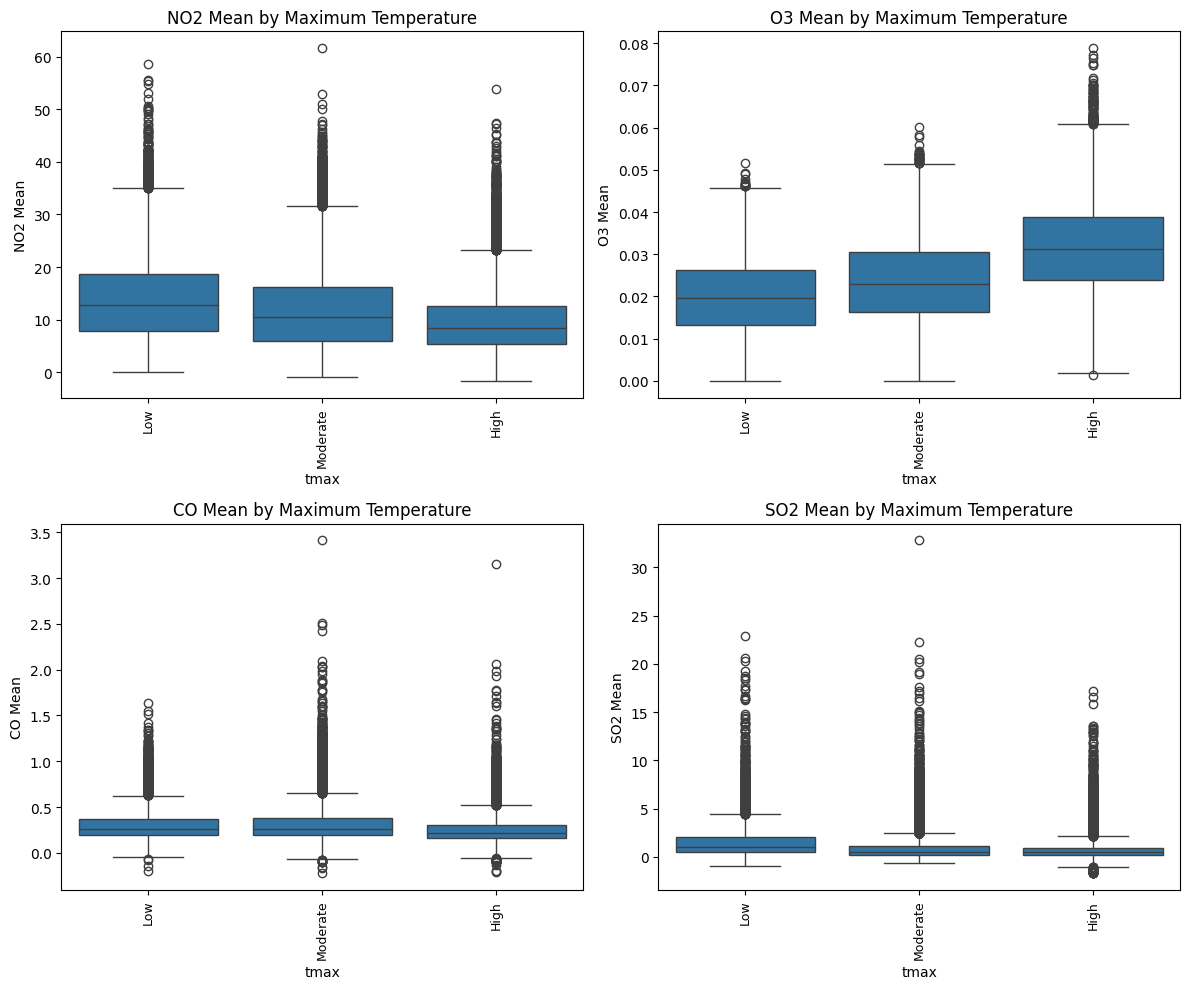

In [14]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Grid size
n = len(pollutants)
ncols = 2
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5*nrows))
axes = axes.flatten()

for idx, col in enumerate(pollutants):
    sns.boxplot(
        x="tmax_bin",
        y=col,
        data=df,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{col} by Maximum Temperature")
    axes[idx].set_xlabel("tmax")
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis="x", rotation=90, labelsize=9)

# Hide unused subplots (if any)
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Next, I will use the non-parametric, Kruskal-Wallis test to assess whether the distributions are significantly different i.e. if each pollutants' mean levels are affected by maximum temperature. The null hypothesis states there are no differences, while the alternate, which can be accepted if p < 0.05, states that they are different.

In [15]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Initialize results list
kruskal_results = []

for col in pollutants:
    try:
        # Run Kruskal-Wallis test
        result = pg.kruskal(data=df, dv=col, between="tmax_bin")
        
        # Append results with the variable name
        kruskal_results.append({
            'variable': col,
            'H': result['H'].iloc[0],          # test statistic
            'pval': result['p-unc'].iloc[0]    # p-value
        })
    except Exception as e:
        print(f"Could not run Kruskal-Wallis for {col}: {e}")
        kruskal_results.append({
            'variable': col,
            'H': None,
            'pval': None
        })

# Convert results to DataFrame
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='pval').reset_index(drop=True)

kruskal_df

variable            H  pval
0  NO2 Mean  2466.313081   0.0
1   O3 Mean  9569.411280   0.0
2   CO Mean  1473.274627   0.0
3  SO2 Mean  2924.409713   0.0

As p < 0.05 for each pollutant, I can accept the alternate hypothesis; the pollutants' mean levels are affected by maximum temperature.

As there is a correlation between mean values and maximum values, and a very tight correlation between maximum values and AQI. I will not be repeating the tests with those values.

---

## Pollutant Levels and Precipitation

Next, I am going to look at the effect of precipitation on pollutant levels. 

In [18]:
bins = [0, 0.1, 5, 20, 50, 350]
labels = ["None", "Light", "Moderate", "Heavy", "Very Heavy"]

df["prcp_bin"] = pd.cut(df["prcp"], bins=bins, labels=labels, include_lowest=True)

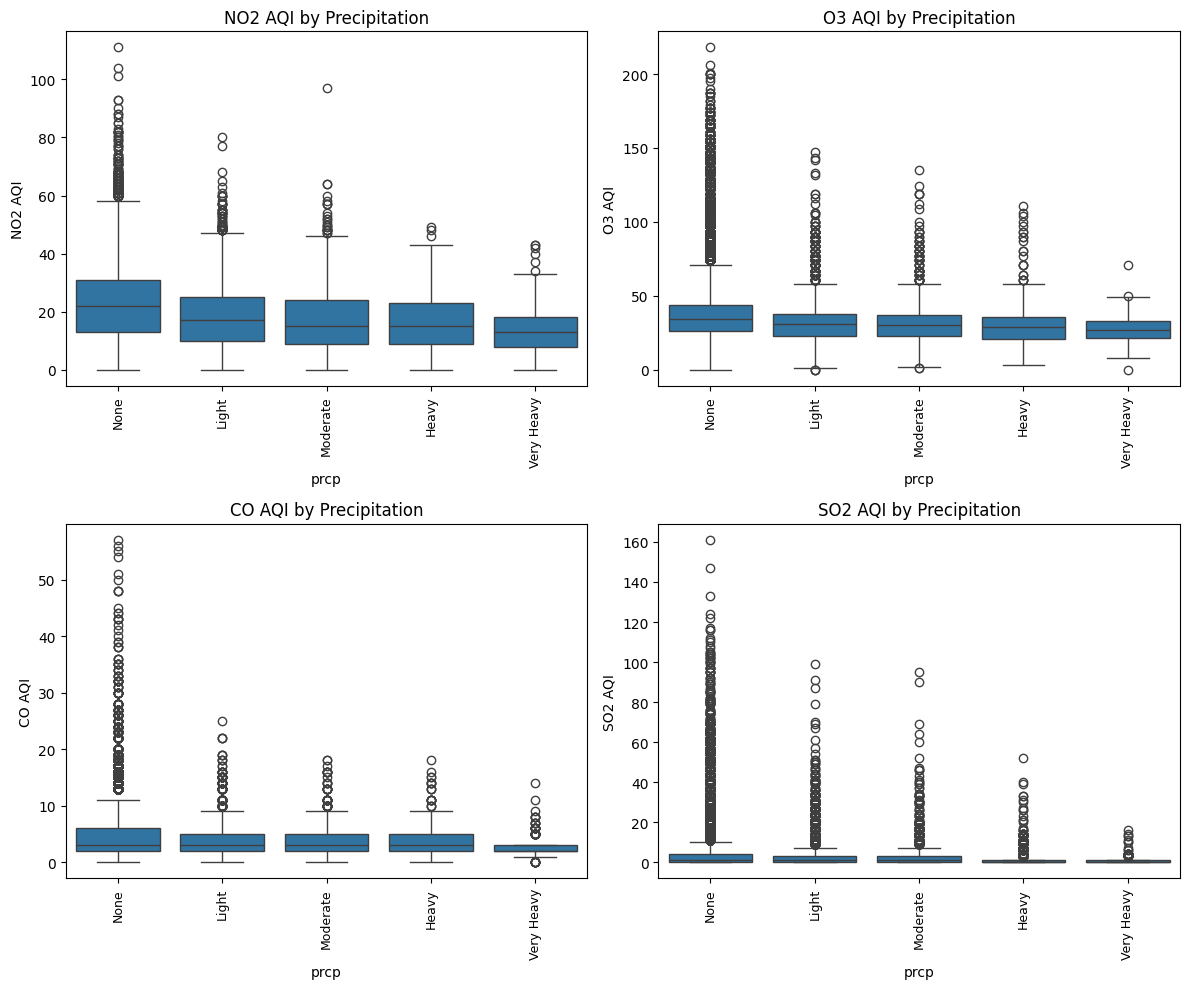

In [19]:
pollutants = ['NO2 AQI', 'O3 AQI', 'CO AQI', 'SO2 AQI']

# Grid size
n = len(pollutants)
ncols = 2
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5*nrows))
axes = axes.flatten()

for idx, col in enumerate(pollutants):
    sns.boxplot(
        x="prcp_bin",
        y=col,
        data=df,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{col} by Precipitation")
    axes[idx].set_xlabel("prcp")
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis="x", rotation=90, labelsize=9)

# Hide unused subplots (if any)
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [20]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Initialize results list
kruskal_results = []

for col in pollutants:
    try:
        # Run Kruskal-Wallis test
        result = pg.kruskal(data=df, dv=col, between="prcp_bin")
        
        # Append results with the variable name
        kruskal_results.append({
            'variable': col,
            'H': result['H'].iloc[0],          # test statistic
            'pval': result['p-unc'].iloc[0]    # p-value
        })
    except Exception as e:
        print(f"Could not run Kruskal-Wallis for {col}: {e}")
        kruskal_results.append({
            'variable': col,
            'H': None,
            'pval': None
        })

# Convert results to DataFrame
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='pval').reset_index(drop=True)

kruskal_df

variable            H           pval
0  NO2 Mean  1166.356033  3.130045e-251
1   CO Mean   551.946960  3.878632e-118
2  SO2 Mean   504.542151  6.976693e-108
3   O3 Mean   353.747589   2.721442e-75

---

## Pollutant Levels by State

The code below will compare each mean pollutant level by state, using box plots.

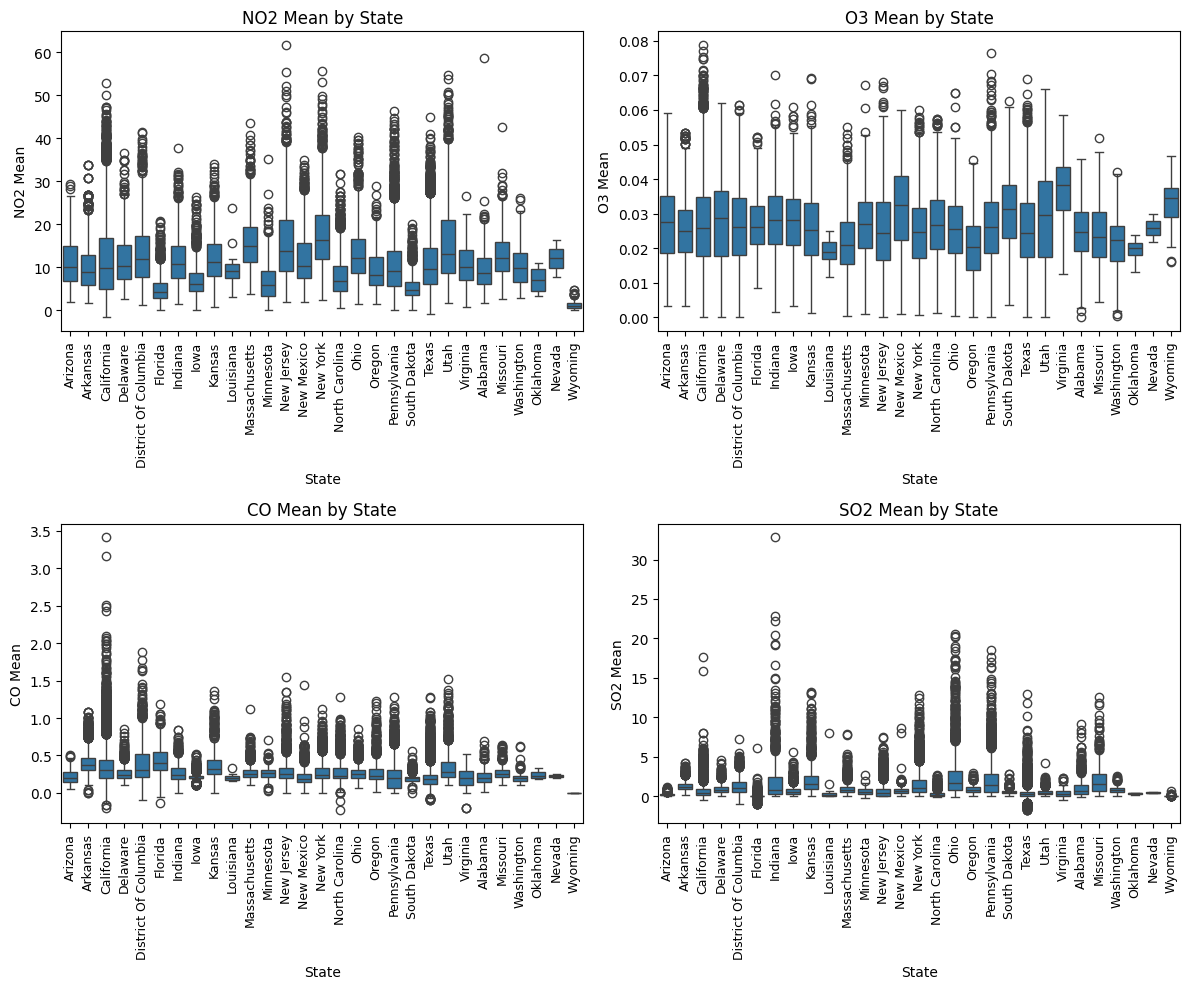

In [26]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Grid size
n = len(pollutants)
ncols = 2
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5*nrows))
axes = axes.flatten()

for idx, col in enumerate(pollutants):
    sns.boxplot(
        x="State",
        y=col,
        data=df,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{col} by State")
    axes[idx].set_xlabel("State")
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis="x", rotation=90, labelsize=9)

# Hide unused subplots (if any)
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From these plots, I can see a lot of variation in mean pollutant by State. For NO2, Wyoming, Florida and South Dakota have the lowest median values, while New York and New Jersey have the highest. 

For O3, Luisiana and Oklahoma have the lowest while Virginia has the highest, however, many states show lots of variance and have values that are often higher than Virginia's. 

For CO, Wyoming has the lowest values while Florida has the highest median. However, California has the highest variance with numerous values higher than the other states.

For SO4, it's quite hard to tell which state has the lowest median value, but Indiana, Ohio and Pensylvania all have some of the highest median values.

Below, I will use the non-parametric Kruskal-Wallis test to check for statistical significance between the distributions of pollutant mean values between states. The hull hypothesis is that there are no differences, while the alternate is that there are.

In [33]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Initialize results list
kruskal_results = []

for col in pollutants:
    try:
        # Run Kruskal-Wallis test
        result = pg.kruskal(data=df, dv=col, between="State")
        
        # Append results with the variable name
        kruskal_results.append({
            'variable': col,
            'H': result['H'].iloc[0],          # test statistic
            'pval': result['p-unc'].iloc[0]    # p-value
        })
    except Exception as e:
        print(f"Could not run Kruskal-Wallis for {col}: {e}")
        kruskal_results.append({
            'variable': col,
            'H': None,
            'pval': None
        })

# Convert results to DataFrame
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='pval').reset_index(drop=True)

kruskal_df

variable             H  pval
0  NO2 Mean   9469.010407   0.0
1   O3 Mean   1666.662762   0.0
2   CO Mean  11337.602946   0.0
3  SO2 Mean  18244.694229   0.0

These results show p < 0.05, therefore I can accept the alternate hypothesis; pollutant means vary statistically by State.

---

## 🌡️🔗 Correlation Heatmap: Weather vs Pollution

This visualization shows the pairwise correlation between selected weather variables and pollutant concentrations. It helps identify potential relationships that may influence air quality patterns.


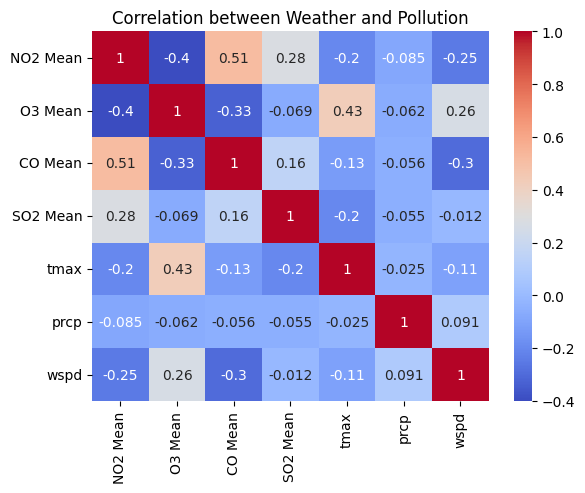

In [14]:
# Cell 15: Correlation heatmap
weather_vars = ['tmax', 'prcp', 'wspd']
corr_df = df[pollutants + weather_vars].corr()

sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation between Weather and Pollution')
plt.show()


In [15]:
import plotly.express as px
import plotly.graph_objects as go


# 🧪 Environmental Data Analysis Pipeline

This workflow performs a comprehensive analysis of air pollution and weather data, including data cleaning, outlier detection, correlation analysis, time series visualization, and hypothesis testing. Each step is designed to support both technical exploration and stakeholder communication.


(53436, 25)
Address                      object
State                        object
County                       object
City                         object
Date Local           datetime64[ns]
NO2 Mean                    float64
NO2 1st Max Value           float64
NO2 1st Max Hour              int64
NO2 AQI                       int64
O3 Mean                     float64
O3 1st Max Value            float64
O3 1st Max Hour               int64
SO2 Mean                    float64
SO2 1st Max Value           float64
SO2 1st Max Hour              int64
CO Mean                     float64
CO 1st Max Value            float64
CO 1st Max Hour               int64
Population                    int32
Latitude                    float64
Longitude                   float64
tmax                        float64
prcp                        float64
wspd                        float64
Year                          int32
dtype: object
            Address    State County    City Date Local   NO2 Mean  \
0  40

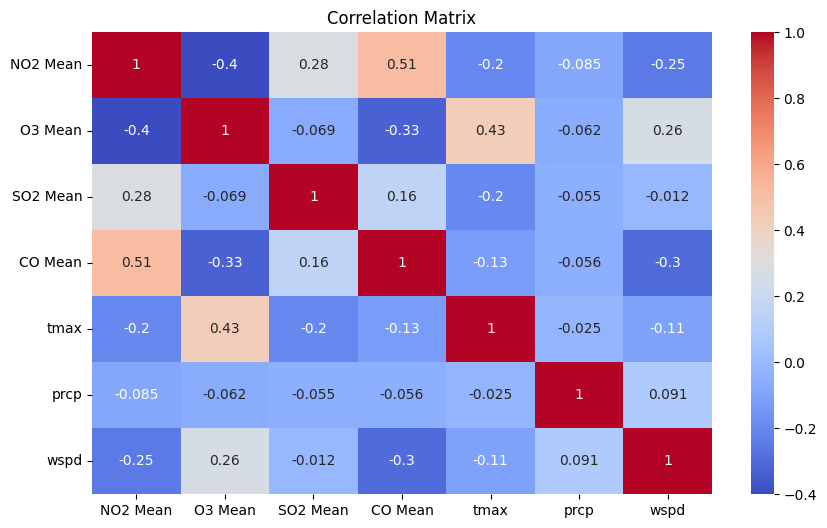

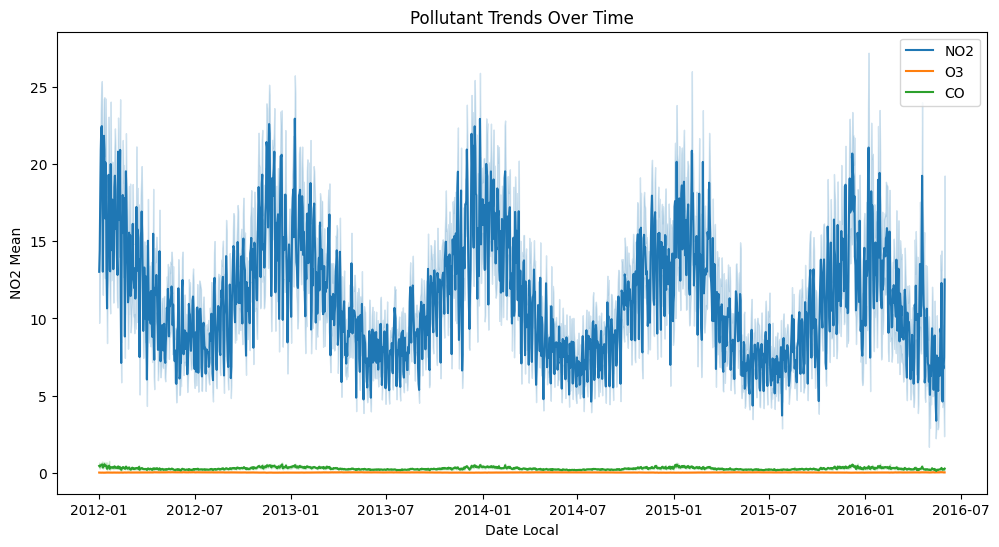

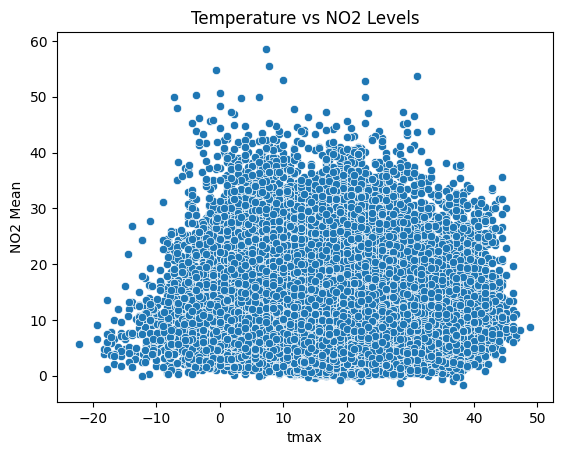

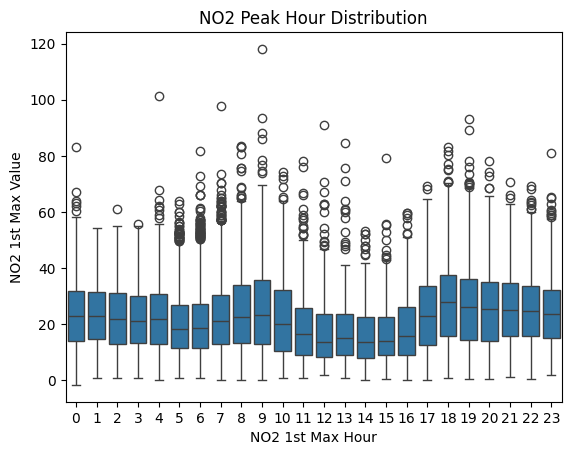

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Data Overview
print(df.shape)
print(df.dtypes)
print(df.head())

# 2. Missing Values
missing = df.isnull().sum()
print("Missing values:\n", missing)

# 3. Data Types and Conversion
df['Date Local'] = pd.to_datetime(df['Date Local'])

# 4. Descriptive Statistics
print(df.describe())

# 5. Outlier Detection (IQR method)
def detect_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    return outliers

outlier_cols = ['NO2 Mean', 'O3 Mean', 'SO2 Mean', 'CO Mean', 'tmax', 'wspd']
for col in outlier_cols:
    outliers = detect_outliers(col)
    print(f"{col}: {len(outliers)} outliers")

# 6. Correlation Analysis
corr = df[['NO2 Mean', 'O3 Mean', 'SO2 Mean', 'CO Mean', 'tmax', 'prcp', 'wspd']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 7. Time Series Trends
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date Local', y='NO2 Mean', label='NO2')
sns.lineplot(data=df, x='Date Local', y='O3 Mean', label='O3')
sns.lineplot(data=df, x='Date Local', y='CO Mean', label='CO')
plt.title("Pollutant Trends Over Time")
plt.legend()
plt.show()

# 8. Hypothesis Testing (example: temp vs NO2)
sns.scatterplot(data=df, x='tmax', y='NO2 Mean')
plt.title("Temperature vs NO2 Levels")
plt.show()

# Optional: Hourly patterns
sns.boxplot(data=df, x='NO2 1st Max Hour', y='NO2 1st Max Value')
plt.title("NO2 Peak Hour Distribution")
plt.show()


## final steps in EDA

Temporal patterns (trends over time)

Correlation analysis

Pollution vs. weather relationships

AQI distribution

Outlier detection


--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58158 entries, 0 to 58157
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Address            58158 non-null  object        
 1   State              58158 non-null  object        
 2   County             58158 non-null  object        
 3   City               58158 non-null  object        
 4   Date Local         58158 non-null  datetime64[ns]
 5   NO2 Mean           58158 non-null  float64       
 6   NO2 1st Max Value  58158 non-null  float64       
 7   NO2 1st Max Hour   58158 non-null  int64         
 8   NO2 AQI            58158 non-null  int64         
 9   O3 Mean            58158 non-null  float64       
 10  O3 1st Max Value   58158 non-null  float64       
 11  O3 1st Max Hour    58158 non-null  int64         
 12  O3 AQI             58158 non-null  int64         
 13  SO2 Mean           58158 non-null  float6

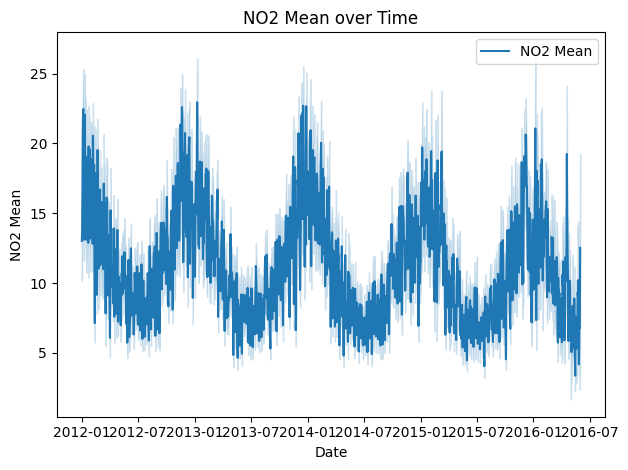

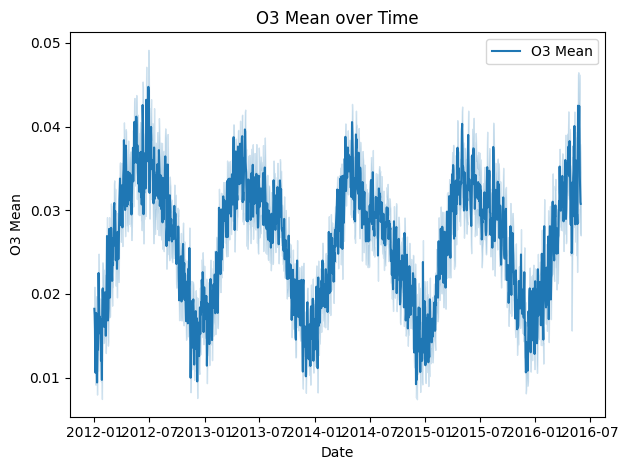

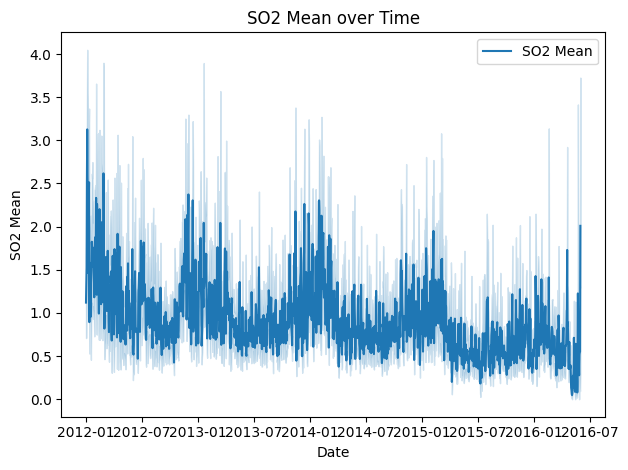

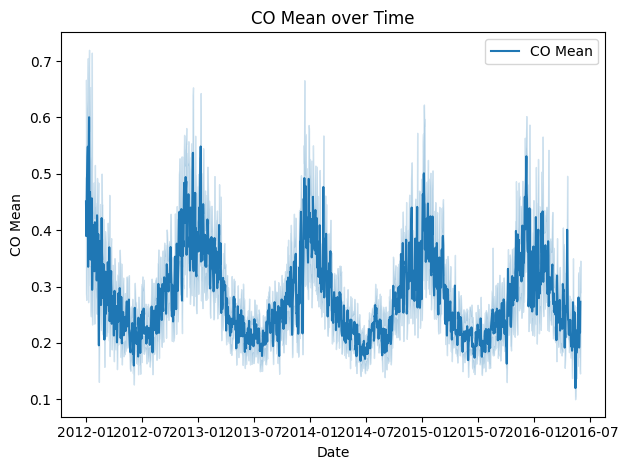

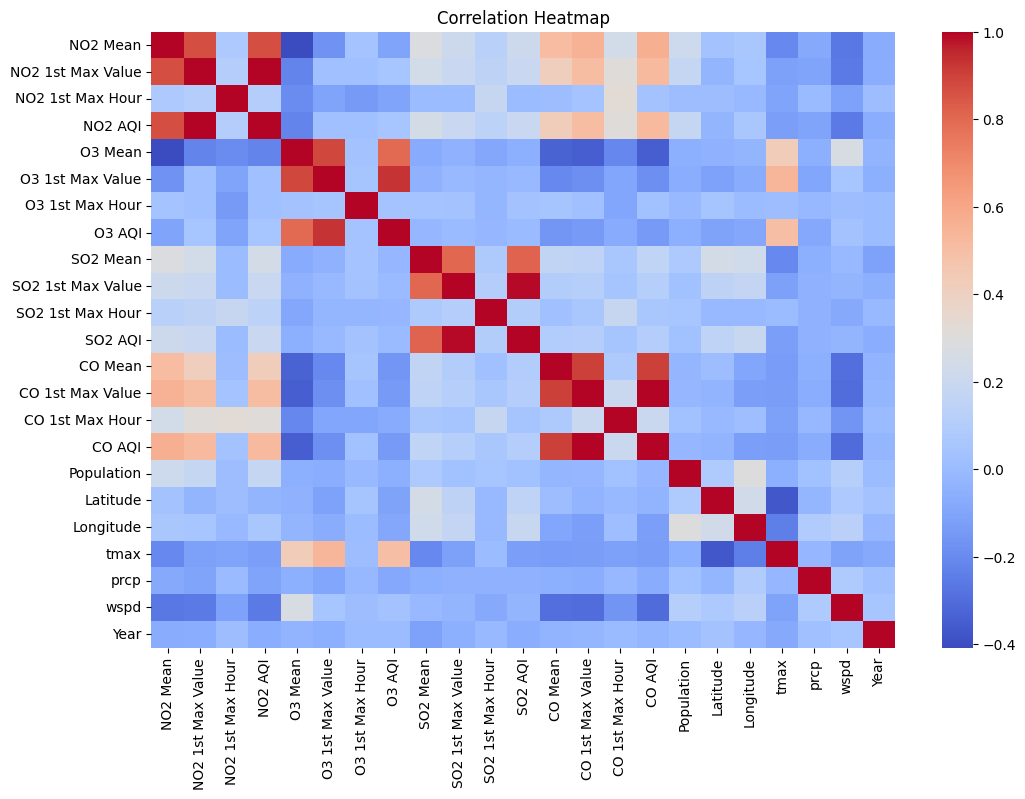


--- Top correlations with NO2 AQI ---
NO2 AQI              1.000000
NO2 1st Max Value    0.999244
NO2 Mean             0.869841
CO AQI               0.518749
CO 1st Max Value     0.510275
CO Mean              0.417194
CO 1st Max Hour      0.307466
SO2 Mean             0.242705
SO2 1st Max Value    0.194191
SO2 AQI              0.193565
Name: NO2 AQI, dtype: float64


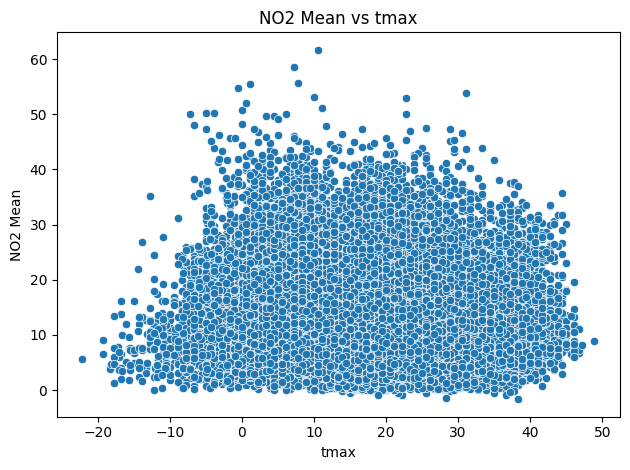

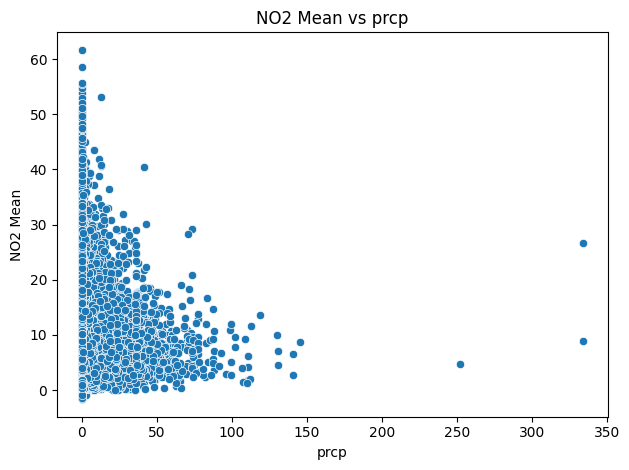

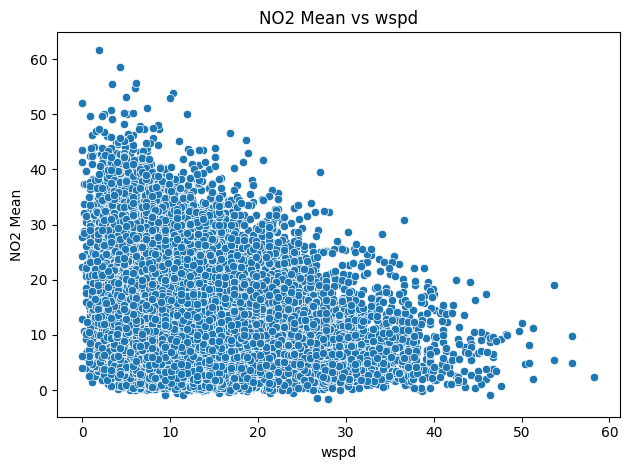

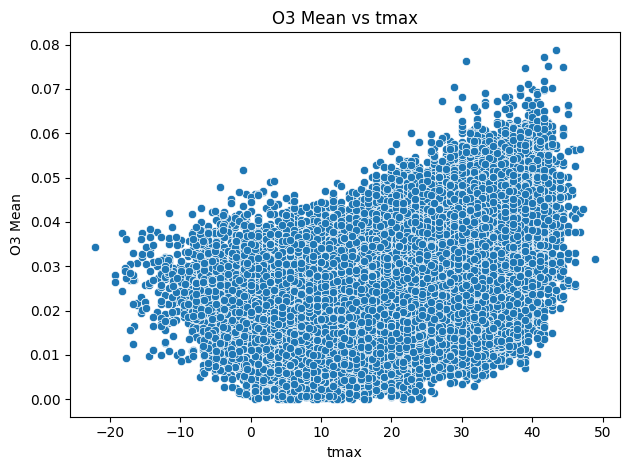

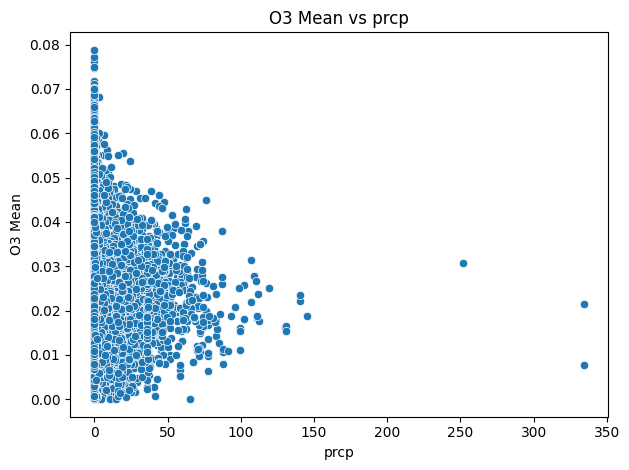

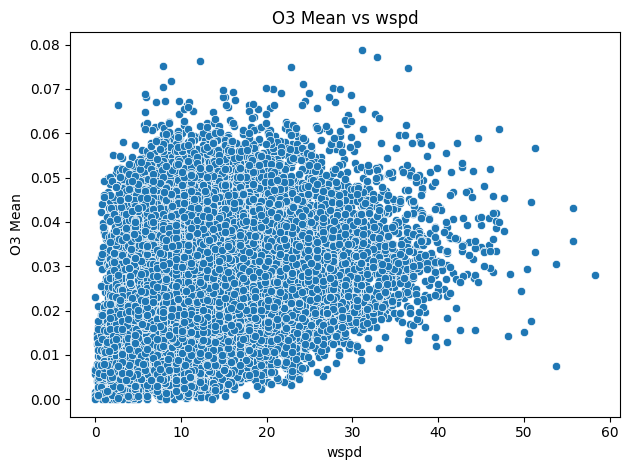

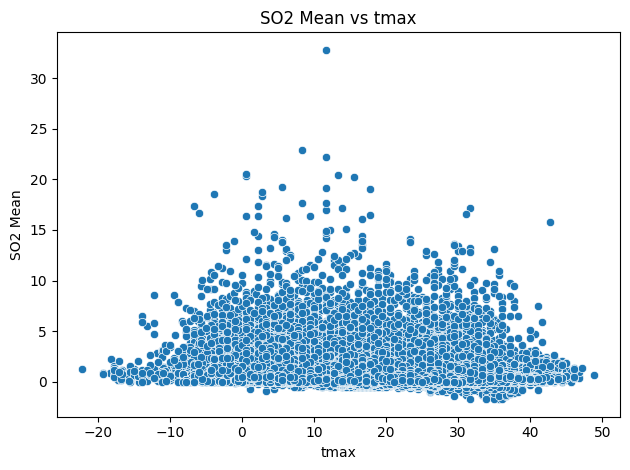

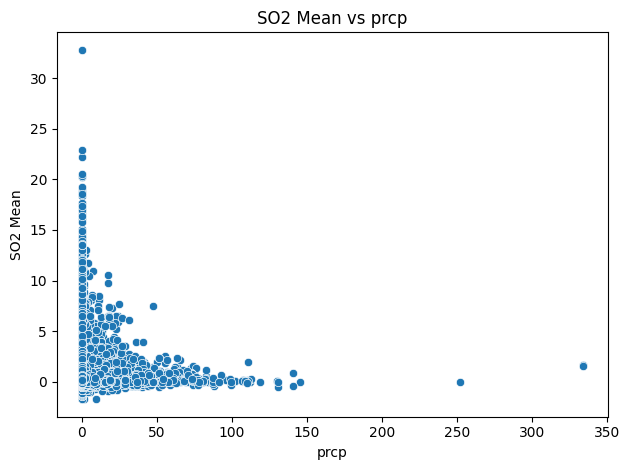

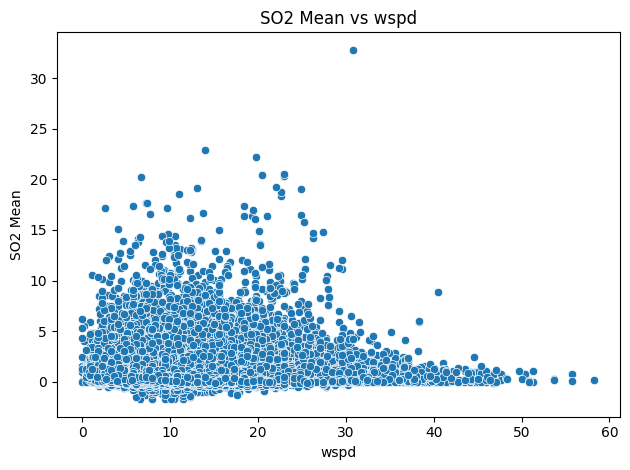

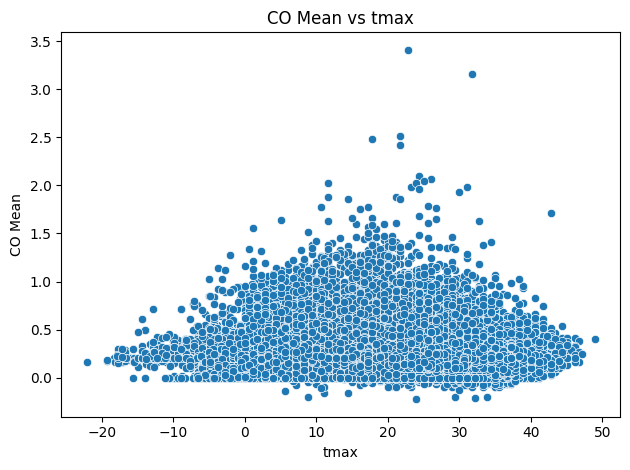

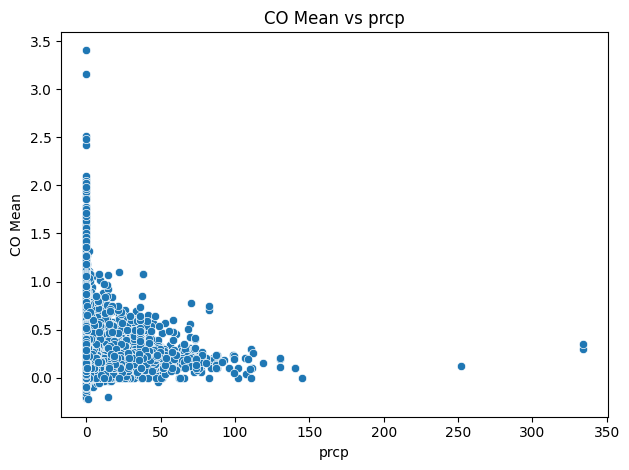

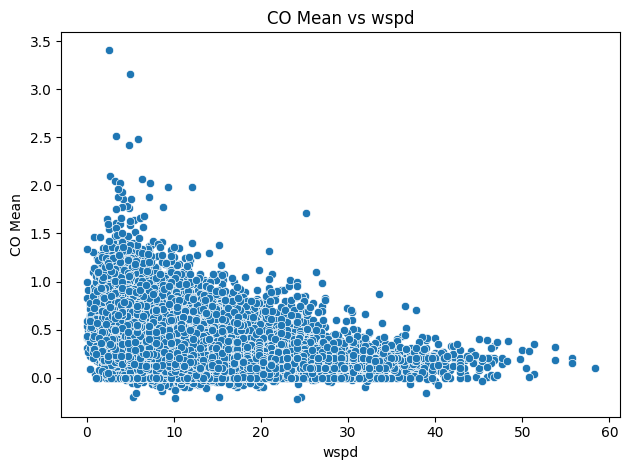

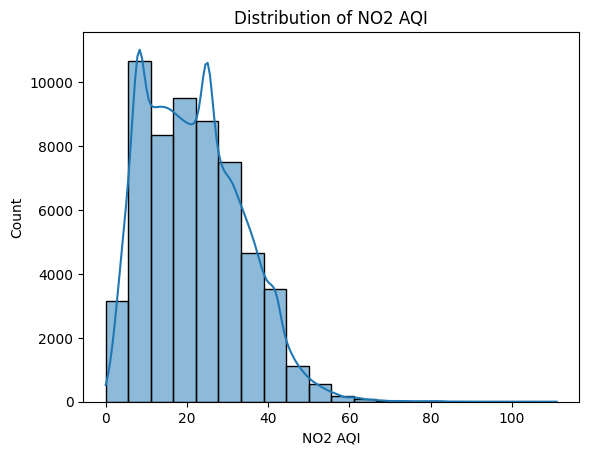

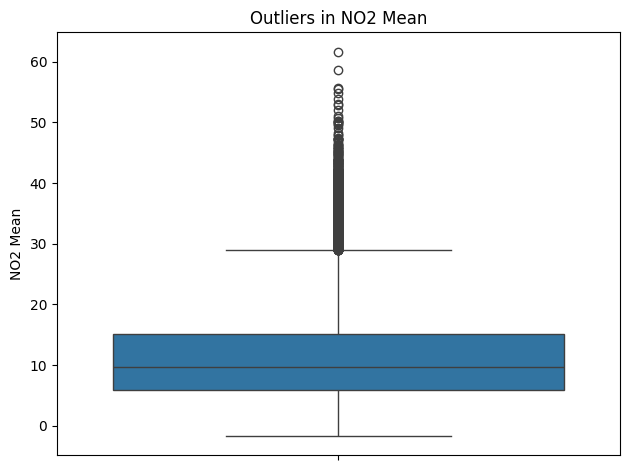

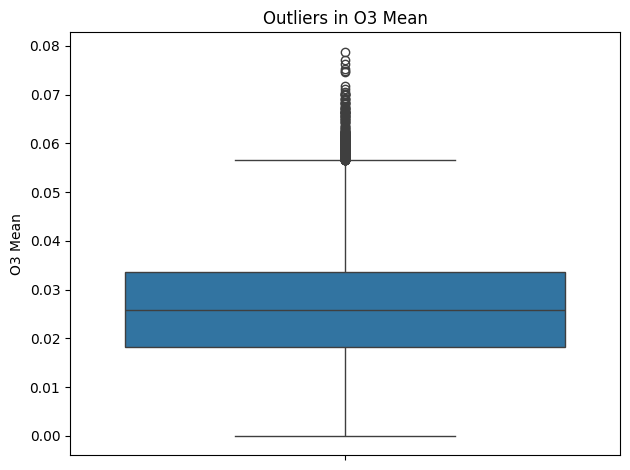

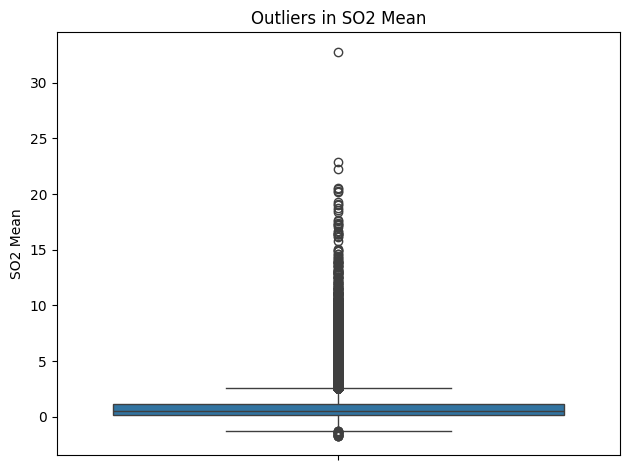

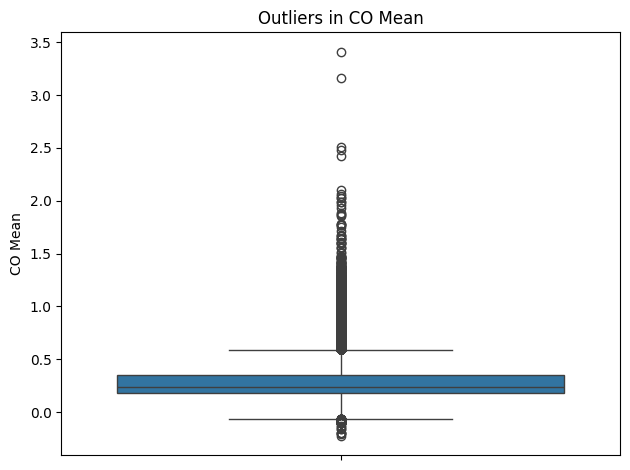

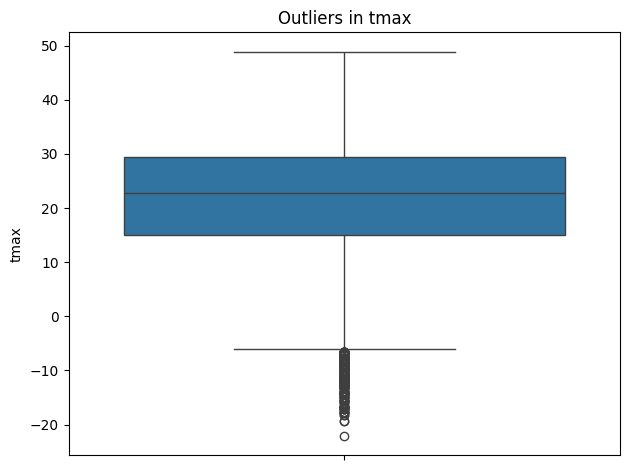

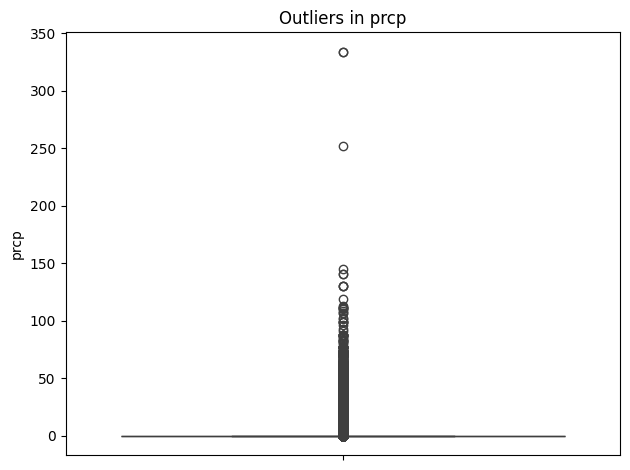

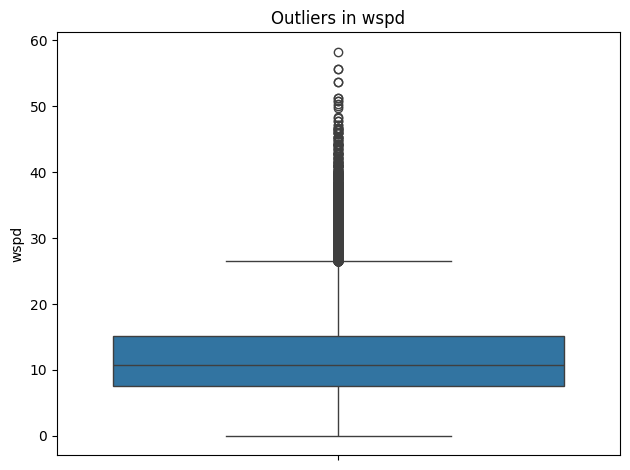

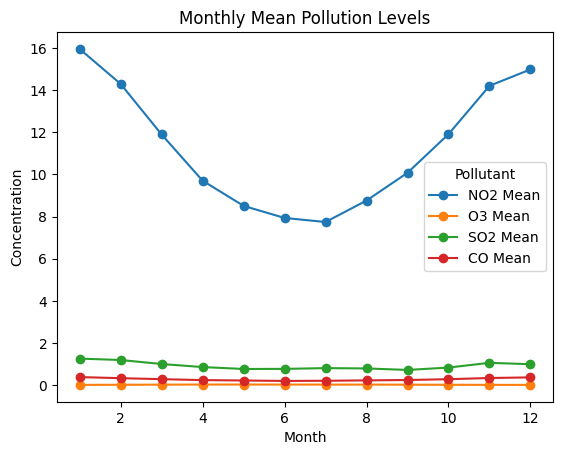

In [39]:
# ===============================
# 3. Basic overview
# ===============================
print("\n--- Basic Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isna().sum())

print("\n--- Descriptive Statistics ---")
print(df.describe().T)

# ===============================
# 4. Time-based trends
# ===============================
pollutants = ['NO2 Mean', 'O3 Mean', 'SO2 Mean', 'CO Mean']
for p in pollutants:
    plt.figure()
    sns.lineplot(data=df, x='Date Local', y=p, label=p)
    plt.title(f'{p} over Time')
    plt.xlabel('Date')
    plt.ylabel(p)
    plt.tight_layout()
    plt.show()

# ===============================
# 5. Correlation Analysis
# ===============================
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

# Find top correlated variables with AQI
if 'NO2 AQI' in df.columns:
    print("\n--- Top correlations with NO2 AQI ---")
    print(corr['NO2 AQI'].sort_values(ascending=False).head(10))

# ===============================
# 6. Pollution vs Weather
# ===============================
weather_vars = ['tmax', 'prcp', 'wspd']

for p in pollutants:
    for w in weather_vars:
        plt.figure()
        sns.scatterplot(data=df, x=w, y=p)
        plt.title(f'{p} vs {w}')
        plt.tight_layout()
        plt.show()

# ===============================
# 7. AQI Distribution
# ===============================
plt.figure()
sns.histplot(df['NO2 AQI'], kde=True, bins=20)
plt.title('Distribution of NO2 AQI')
plt.xlabel('NO2 AQI')
plt.show()

# ===============================
# 8. Outlier Detection (Boxplots)
# ===============================
for p in pollutants + weather_vars:
    plt.figure()
    sns.boxplot(data=df, y=p)
    plt.title(f'Outliers in {p}')
    plt.tight_layout()
    plt.show()

# ===============================
# 9. Optional: Daily/Monthly Aggregation
# ===============================
df['Month'] = df['Date Local'].dt.month
monthly_mean = df.groupby('Month')[pollutants].mean()

monthly_mean.plot(marker='o')
plt.title('Monthly Mean Pollution Levels')
plt.xlabel('Month')
plt.ylabel('Concentration')
plt.legend(title='Pollutant')
plt.show()

(On this process you can see that How pollutants vary over time (e.g., spikes, trends)

Which pollutants correlate with temperature or wind speed

How weather affects air quality

Which variables show outliers or anomalies

Correlation patterns — e.g., high NO₂ AQI might correlate with low wind speeds)

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.